In [1057]:
import numpy as np
from matplotlib import pyplot as plt
import time
import torch
from torch import nn
import os

## Objective Funtions

In [279]:
def sphere(x):
    return torch.sum(x**2)

In [1025]:
elli_coeffs = torch.ones(2)
def ellipsoid(x):
    n = x.size(0)
    global elli_coeffs
    elli_coeffs = torch.pow(10, torch.arange(n)/(n-1))
    return torch.sum(elli_coeffs * x**2)

In [281]:
def cigar(x):
    return x[0]**2 + 10**6 * torch.sum(x[1:]**2)

In [282]:
def tablet(x):
    return 10**6 * x[0]**2 + torch.sum(x[1:]**2)

In [283]:
def parabolic_ridge(x):
    return -x[0] + 100*torch.sum(x[1:]**2)

In [284]:
def sharp_ridge(x):
    return -x[0] + 100*torch.norm(x[1:])

In [285]:
def diffpow(x):
    n = x.size(0)
    out = 0
    for i in range(n):
        out += torch.abs(x[i])**(2 + 10*i/(n-1))
    return out

In [286]:
def rosenbrock(x):
    n = x.size(0)
    out = 0
    for i in range(n-1):
        out += 100*(x[i+1] - x[i]**2)**2 + (x[i] - 1)**2
    return out

In [287]:
#NOTE: Only takes x in R^2
def booth(x):
    return (x[0] + 2*x[1] - 7)**2 + (2*x[0] + x[1] - 5)**2

In [627]:
def multi_layer_init(num_samples, in_dim, out_dim, w_dims, seed=12345):
    #NOTE: w_dims[0] must equal in_dim and w_dims[-1] must equal out_dim
    torch.manual_seed(seed)
    
    X = torch.rand(in_dim, num_samples, requires_grad=True)
    Y = torch.rand(out_dim, num_samples, requires_grad=True)
    
    return X, Y

In [1183]:
#multi layer nn
sigma = nn.LeakyReLU(0.1)
sigma_inv = nn.LeakyReLU(10)

def multi_layer(w):
    h = X
    start = 0
    for i in range(len(w_dims)-1):
        end = start + w_dims[i]*w_dims[i+1]
        cur_w = w[start:end].reshape(w_dims[i+1],w_dims[i])
        h = sigma(torch.matmul(1.0000*cur_w, h))
        start = end
    return 0.5 * torch.norm(Y - h)**2

# Gradient-Based Optimization Methods

Source: https://algorithmsbook.com/optimization/files/optimization.pdf

In [292]:
#Gradient Descent
def gd_step(x, obj, params):
    lr = params["lr"]
    
    loss = obj(x)
    grad, = torch.autograd.grad(loss, inputs=x)
    x_new = x - lr*grad
    return x_new

In [293]:
#Momentum
def momentum_step(x, obj, params):
    lr = params["lr"]
    v = params["v"]
    decay = params["decay"]
    
    loss = obj(x)
    grad, = torch.autograd.grad(loss, inputs=x)
    v_new = decay*v - lr*grad
    x_new = x + v_new
    return x_new, v_new

In [294]:
#AdaGrad
def adagrad_step(x, obj, params):
    lr = params["lr"]
    s = params["s"]
    
    loss = obj(x)
    grad, = torch.autograd.grad(loss, inputs=x)
    s_new = s + grad**2
    x_new = x - (lr / (10e-8 + torch.sqrt(s_new)))*grad
    return x_new, s_new

In [296]:
#Adam
def adam_step(x, obj, params):
    v = params["v"]
    v_decay = params["v_decay"]
    s = params["s"]
    s_decay = params["s_decay"]
    lr = params["lr"]
    k = params["k"] #stores number of iterations
    
    k += 1
    
    loss = obj(x)
    grad, = torch.autograd.grad(loss, inputs=x)
    
    v_new = v_decay*v + (1-v_decay)*grad
    s_new = s_decay*s + (1-s_decay)*(grad**2)
    
    v_hat = v_new / (1 - v_decay**k)
    s_hat = s_new / (1 - s_decay**k)
    
    x_new = x - lr * v_hat / (1e-8 + torch.sqrt(s_hat))
    return x_new, v_new, s_new, k

## CMA-ES

Source: http://www.cmap.polytechnique.fr/~nikolaus.hansen/evco_11_1_1_0.pdf

In [865]:
def oldcmaes_step(x, obj, params):
    l = params["l"]
    mu = params["mu"]
    C = params["C"]
    pc = params["pc"]
    cc = params["cc"]
    ccov = params["ccov"]
    s = params["s"]
    ps = params["ps"]
    cs = params["cs"]
    ds = params["ds"]
    chi = params["chi"]
    n = x.size(0)
    
    #compute B and D
    B, D_squared, B_transpose = torch.linalg.svd(C)
    D = torch.diag(torch.sqrt(D_squared))
    BD = torch.matmul(B,D)
    
    #Sample offspring
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(n), torch.eye(n))
    z = m.sample((l,))
    offspring = x + s * torch.t(torch.matmul(BD, torch.t(z)))
        
    #Compute objective on each offspring
    evals = torch.zeros(l)
    for i in range(l):
        evals[i] = obj(offspring[i])
        
    #Get indices of top mu offspring
    top_evals, top_inds = torch.topk(evals, mu, largest=False)
    
    #Updates
    x_new = (1/mu) * torch.sum(offspring[top_inds], dim=0)
    z_avg = (1/mu) * torch.sum(z[top_inds], dim=0)
        
    #Covariance update
    pc_new = (1-cc)*pc + np.sqrt(cc*(2-cc)*mu) * torch.matmul(BD, z_avg)
    C_new = (1-ccov)*C + ccov*torch.outer(pc_new, pc_new)
    
    #Step size update
    ps_new = (1-cs)*ps + np.sqrt(cs*(2-cs)*mu) * torch.matmul(B, z_avg)
    s_new = s * torch.exp((1/ds) * (torch.norm(ps_new)-chi) / chi)
    
    return x_new, C_new, pc_new, s_new, ps_new

Source: http://www.cmap.polytechnique.fr/~nikolaus.hansen/evco_11_1_1_0.pdf

In [829]:
def newcmaes_step(x, obj, params):
    l = params["l"]
    mu = params["mu"]
    C = params["C"]
    pc = params["pc"]
    cc = params["cc"]
    ccov = params["ccov"]
    acov = params["acov"]
    s = params["s"]
    ps = params["ps"]
    cs = params["cs"]
    ds = params["ds"]
    chi = params["chi"]
    n = x.size(0)
    
    #compute B and D
    B, D_squared, B_transpose = torch.linalg.svd(C)
    D = torch.diag(torch.sqrt(D_squared))
    BD = torch.matmul(B,D)
    
    #Sample offspring
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(n), torch.eye(n))
    z = m.sample((l,))
    offspring = x + s * torch.t(torch.matmul(BD, torch.t(z)))
        
    #Compute objective on each offspring
    evals = torch.zeros(l)
    for i in range(l):
        evals[i] = obj(offspring[i])
        
    #Get indices of top mu offspring
    top_evals, top_inds = torch.topk(evals, mu, largest=False)
    
    #Updates
    x_new = (1/mu) * torch.sum(offspring[top_inds], dim=0)
    z_avg = (1/mu) * torch.sum(z[top_inds], dim=0)
    
    #Covariance update
    pc_new = (1-cc)*pc + np.sqrt(cc*(2-cc)*mu) * torch.matmul(BD, z_avg)
    
    outer_prod_sum = torch.zeros(n,n)
    for i in range(mu):
        outer_prod_sum += (1/mu) * torch.outer(z[top_inds[i]], z[top_inds[i]])
    bigZ = torch.matmul(BD, torch.matmul(outer_prod_sum, torch.t(BD)))
    
    C_new = ((1-ccov)*C + 
             ccov * (acov*torch.matmul(pc_new, torch.t(pc_new)) +
                     (1-acov)*bigZ))
    
    #Step size update
    ps_new = (1-cs)*ps + np.sqrt(cs*(2-cs)*mu) * torch.matmul(B, z_avg)
    s_new = s * torch.exp((1/ds) * (torch.norm(ps_new)-chi) / chi)
    
    return x_new, C_new, pc_new, s_new, ps_new

Source: https://arxiv.org/pdf/1604.00772.pdf (see pg. 29)

In [912]:
def cmaes_step(x, obj, params):
    #Set parameters
    l = params["l"]
    mu = params["mu"]
    mu_eff = params["mu_eff"]
    C = params["C"]
    pc = params["pc"]
    cc = params["cc"]
    cm = params["cm"]
    c1 = params["c1"]
    cmu = params["cmu"]
    s = params["s"]
    ps = params["ps"]
    cs = params["cs"]
    ds = params["ds"]
    chi = params["chi"]
    w = params["w"]
    sumw = params["sumw"]
    epoch = params["epoch"]
    n = x.size(0)
    
    #Calculate B,D
    B, D_squared_diag, B_transpose = torch.linalg.svd(C)
    D_diag = torch.sqrt(D_squared_diag)
    D = torch.diag(D_diag)
    Dinv = torch.diag(1/D_diag)
    BD = torch.matmul(B,D)
    sqrtCinv = torch.matmul(B, torch.matmul(Dinv, B_transpose))
    
    #Sample offspring
    m = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(n), torch.eye(n))
    z = m.sample((l,))
    y = torch.t(torch.matmul(BD, torch.t(z)))
    offspring = x + s*y
    
    #Compute objective on each offspring
    evals = torch.zeros(l)
    for i in range(l):
        evals[i] = obj(offspring[i])
    
    #Get indices of top mu offspring
    top_evals, top_inds = torch.topk(evals, l, largest=False)
    
    #Selection and recombination
    y_avg = torch.zeros(n)
    for i in range(mu):
        y_avg += w[i] * y[top_inds[i]]
    x_new = x + cm*s*y_avg
    
    #Step size update
    ps_new = (1-cs)*ps + np.sqrt(cs*(2-cs)*mu_eff) * torch.matmul(sqrtCinv, y_avg)
    s_new = s * torch.exp((cs/ds) * (torch.norm(ps)/chi - 1))

    #Covariance update    
    term1 = torch.norm(ps) / torch.sqrt(1 - (1-cs)**(2*(epoch+1)))
    term2 = (1.4 + 2/(n+1))*chi
    if term1 < term2:
        hs = 1
    else:
        hs = 0
    dhs = (1-hs) * cc * (2-cc)
    
    w_circle = torch.zeros(l)
    w_circle[:mu] = w[:mu]
    for i in range(mu, l):
        w_circle[i] = w[i] * n / torch.norm(torch.matmul(sqrtCinv, y[top_inds[i]]))**2
    
    pc_new = (1-cc)*pc + hs*np.sqrt(cc*(2-cc)*mu_eff)*y_avg

    outer_prod_sum = torch.zeros(n,n)
    for i in range(l):
        outer_prod_sum += w_circle[i] * torch.outer(y[top_inds[i]], y[top_inds[i]])
    
    C_new = ((1 + c1*dhs - c1 - cmu*sumw)*C +
         c1*torch.outer(pc, pc) +
         cmu*outer_prod_sum)
    
    return x_new, C_new, pc_new, s_new, ps_new

# Teleportation

In [300]:
#Booth x to v
def booth_x_to_v(x):
    return torch.stack([x[0] + 2*x[1] - 7, 2*x[0] + x[1] - 5])

def booth_v_to_x(v):
    return torch.stack([-1/3*v[0] + 2/3*v[1] + 1, 2/3*v[0] - 1/3*v[1] + 3])

In [301]:
#Rosenbrock x to v
def ros_x_to_v(x):
    return torch.stack([10 * (x[0]**2 - x[1]), x[0] - 1])

def ros_v_to_x(v):
    return torch.stack([v[1] + 1, (v[1] + 1)**2 - v[0] / 10])

In [531]:
#Sphere x to v
def sphere_x_to_v(x):
    return x

def sphere_v_to_x(v):
    return v

In [550]:
#Ellipsoid x to v
def elli_x_to_v(x):
    return torch.sqrt(elli_coeffs) * x

def elli_v_to_x(v):
    return (1/torch.sqrt(elli_coeffs)) * v

In [302]:
def group_action_SO2(x, g, x_to_v, v_to_x):
    """SO(2) group action on a 2D vector.

    Args:
        x: The vector acted upon.
        g: A 2x2 rotation matrix. Group element that acts on the vector.
        x_to_v: A function that takes input x and outputs v where SO(2) acts 
          linearly on vector v
        v_to_x: A function that takes input v and outputs x. Inverse function
          x_to_v.

    Returns:
        Two numbers corresponding to g.[x,y], where . denotes the action map.
    """
    v = x_to_v(x)
    rotated_v = torch.einsum('ij,j->i', g, v)
    return v_to_x(rotated_v)

In [1123]:
def teleport_SO2(x, x_to_v, v_to_x, loss_func, lr_theta):
    """Teleportation on a function with SO(2) symmetry.

    Args:
        x: The vector acted upon.
        x_to_v: A function that takes input x and outputs v where SO(2) acts 
          linearly on vector v
        v_to_x: A function that takes input v and outputs x. Inverse function
          x_to_v.
        loss_func: Loss function in the optimization problem.
        lr_theta: A scalar. Learning rate used in optimizing the group element.

    Returns:
        Two numbers corresponding to g.x, where g is the optimal group element found.
    """
    theta = torch.tensor(np.random.random() * np.pi, requires_grad=True)
    for theta_step in range(10):
        g = torch.vstack(( \
            torch.cat(( (torch.cos(theta)).view(1), (-torch.sin(theta)).view(1) )), \
            torch.cat(( (torch.sin(theta)).view(1), (torch.cos(theta)).view(1))) \
            ))
        gx = group_action_SO2(x, g, x_to_v, v_to_x)

        L = loss_func(gx)
        dL_dgW, = torch.autograd.grad(L, inputs=[gx], create_graph=True)
        dL_dt = torch.sum(torch.square(dL_dgW))
        dLdt_dtheta = torch.autograd.grad(dL_dt, inputs=[theta])[0]
        
        theta = theta + lr_theta * dLdt_dtheta

    x = torch.tensor(gx.detach().numpy(), requires_grad=True)
    return x


## Optimizer Wrapper

In [1125]:
def step(optimizer, x, obj, teleport):
    if teleport:
        if obj == booth:
            x = teleport_SO2(x, booth_x_to_v, booth_v_to_x, obj, 0.001)
        elif obj == rosenbrock:
            x = teleport_SO2(x, ros_x_to_v, ros_v_to_x, obj, 0.1)
        elif obj == sphere:
            x = teleport_SO2(x, sphere_x_to_v, sphere_v_to_x, obj, 0.01)
        elif obj == ellipsoid:
            x = teleport_SO2(x, elli_x_to_v, elli_v_to_x, obj, 0.01)
        else:
            print("WARNING: CANNOT TELEPORT ON", obj)
    
    if optimizer == "gd":
        x_new = gd_step(x, obj, parameters["gd"])
        
    elif optimizer == "momentum":
        x_new, v_new = momentum_step(x, obj, parameters["momentum"])
        parameters["momentum"]["v"] = v_new
        
    elif optimizer == "adagrad":
        x_new, s_new = adagrad_step(x, obj, parameters["adagrad"])
        parameters["adagrad"]["s"] = s_new
        
    elif optimizer == "rmsprop":
        pass
    
    elif optimizer == "adam":
        x_new, v_new, s_new, k = adam_step(x, obj, parameters["adam"])
        parameters["adam"]["v"] = v_new
        parameters["adam"]["s"] = s_new
        parameters["adam"]["k"] = k
    
    elif optimizer == "oldcmaes":
        x_new, C_new, pc_new, s_new, ps_new = oldcmaes_step(x, obj, parameters["oldcmaes"])
        parameters["oldcmaes"]["C"] = C_new
        parameters["oldcmaes"]["pc"] = pc_new
        parameters["oldcmaes"]["s"] = s_new
        parameters["oldcmaes"]["ps"] = ps_new
        
    elif optimizer == "newcmaes":
        x_new, C_new, pc_new, s_new, ps_new = newcmaes_step(x, obj, parameters["newcmaes"])
        parameters["newcmaes"]["C"] = C_new
        parameters["newcmaes"]["pc"] = pc_new
        parameters["newcmaes"]["s"] = s_new
        parameters["newcmaes"]["ps"] = ps_new
        
    elif optimizer == "cmaes":
        x_new, C_new, pc_new, s_new, ps_new = cmaes_step(x, obj, parameters["cmaes"])
        parameters["cmaes"]["C"] = C_new
        parameters["cmaes"]["pc"] = pc_new
        parameters["cmaes"]["s"] = s_new
        parameters["cmaes"]["ps"] = ps_new
        parameters["cmaes"]["epoch"] = parameters["cmaes"]["epoch"] + 1
    
    else:
        print("Optimizer", optimizer, "not found.")
        
    return x_new

# Parameters

In [936]:
def set_param(params, opt, param, new_value):
    params[opt][param] = new_value

In [926]:
def set_default_params(n):
    gd_params = {
        "lr": 0.002
    }

    momentum_params = {
        "lr": 0.002,
        "v": 0,
        "decay": 0.5
    }

    adagrad_params = {
        "lr": 1,
        "s": 0
    }

    adam_params = {
        "lr": 0.08,
        "v": 0,
        "s": 0,
        "v_decay": 0.9,
        "s_decay": 0.999,
        "k": 0
    }
    
    #OLD/NEW CMAES PARAMETERS
    l = 200#int(4 + np.floor(3*np.log(n)))
    mu = 10#int(np.floor(l/4))
    chi = np.sqrt(n) * (1 - 1/(4*n) + 1/(21*n**2))
    acov = 1/mu
    
    oldcmaes_params = {
        "l": l,
        "mu": mu,
        "C": torch.eye(n),
        "pc": torch.zeros(n),
        "cc": 4 / (n+4),
        "ccov": 2 / (n + np.sqrt(2))**2,
        "s": 0.1,
        "ps": torch.zeros(n),
        "cs": 4/(n+4),
        "ds": 1 + (n+4)/4,
        "chi": chi
    }
    
    newcmaes_params = {
        "l": l,
        "mu": mu,
        "C": torch.eye(n),
        "pc": torch.zeros(n),
        "cc": 4 / (n+4),
        "ccov": acov*2/(n+np.sqrt(2))**2 + (1-acov)*min(1, (2*mu-1)/((n+2)**2 + mu)),
        "acov": acov,
        "s": 0.01,
        "ps": torch.zeros(n),
        "cs": 4/(n+4),
        "ds": 1 + (n+4)/4,
        "chi": chi
    }
    
    #CMAES PARAMETERS
    l = int(4 + np.floor(3 * np.log(n)))
    mu = int(np.floor(l/2))
    
    w_prime = np.log((l+1)/2) - torch.log(torch.arange(1,l+1))
        
    mu_eff = (torch.sum(w_prime[:mu])**2) / torch.sum(w_prime[:mu]**2)
    mu_eff_neg = (torch.sum(w_prime[mu:])**2) / torch.sum(w_prime[mu:]**2)
    
    cm = 1
    
    cs = (mu_eff + 2) / (n + mu_eff + 5)
    ds = 1 + 2 * max(0, np.sqrt((mu_eff-1)/(n+1))-1) + cs
    
    cc = (4 + mu_eff/n) / (n + 4 + 2*mu_eff/n)
    c1 = 2 / ((n+1.3)**2 + mu_eff)
    cmu = min(1-c1, 2*(1/4 + mu_eff + 1/mu_eff - 2)/((n+2)**2 + mu_eff))
    
    amu = 1 + c1/cmu
    amu_eff = 1 + (2*mu_eff_neg) / (mu_eff + 2)
    a_pd = (1 - c1 - cmu) / (n*cmu)
    
    sum_w_prime_pos = torch.sum(w_prime[:mu])
    sum_w_prime_neg = -torch.sum(w_prime[mu:])
    
    w = torch.zeros(l)
    w[:mu] = w_prime[:mu] / sum_w_prime_pos
    w[mu:] = min(amu, amu_eff, a_pd) * w_prime[mu:] / sum_w_prime_neg
    sumw = torch.sum(w)
    
    chi = np.sqrt(n) * (1 - 1/(4*n) + 1/(21*n**2))
    
    cmaes_params = {
        "l": l,
        "mu": mu,
        "mu_eff": mu_eff,
        "C": torch.eye(n),
        "pc": torch.zeros(n),
        "cc": cc,
        "cm": cm,
        "c1": c1,
        "cmu": cmu,
        "s": 0.1,
        "ps": torch.zeros(n),
        "cs": cs,
        "ds": ds,
        "chi": chi,
        "w": w,
        "sumw": sumw,
        "epoch": 0
    }

    parameters = {
        "gd": gd_params,
        "momentum": momentum_params,
        "adagrad": adagrad_params,
        "adam": adam_params,
        "oldcmaes": oldcmaes_params,
        "newcmaes": newcmaes_params,
        "cmaes": cmaes_params
    }
    
    return parameters

## Training

In [940]:
def train(obj, opt, epochs, x, teleport_sched):
    loss_vals = np.zeros(epochs+1)
    times = np.zeros(epochs+1)
    loss_vals[0] = obj(x)
    
    start = time.time()

    for epoch in range(epochs):
        if epoch in teleport_sched:
            x = step(opt, x, obj, True)
        else:
            x = step(opt, x, obj, False)
                            
        loss_vals[epoch+1] = obj(x).item()
        times[epoch+1] = time.time() - start
        
    return x, loss_vals, times

In [941]:
def train_time(obj, opt, runtime, x, teleport_sched):
    loss_vals = [obj(x).item()]
    times = [0]
    
    start = time.time()

    epoch = 0
    while time.time()-start < runtime:
        if epoch in teleport_sched:
            x = step(opt, x, obj, True)
        else:
            x = step(opt, x, obj, False)
            
        loss_vals.append(obj(x).item())
        times.append(time.time() - start)
        
        epoch += 1
        
    return x, loss_vals, times

In [1090]:
def loss_vs_epochs(obj, opts, epochs, x_init, tel_scheds, param_changes=[], figsz=(13,9)):
    plt.figure(figsize=figsz)
    labels = opts.copy()
    global parameters
    
    for i in range(len(opts)):
        opt = opts[i]
        tel_sched = tel_scheds[i]
        
        parameters = set_default_params(x_init.size(0))
        parameters = set_default_params(x_init.size(0))
        for change in param_changes:
            set_param(parameters, change[0], change[1], change[2])
        
        x, loss_vals, times = train(obj, opt, epochs, x_init, tel_sched)
        plt.plot(np.arange(epochs+1), loss_vals)
        
        if len(tel_sched) > 0:
            labels[i] += " w/ tel"
            
        print("Total time elapsed using", labels[i], "-", times[-1])
        print("Final x -", x)
        print("Final loss -", obj(x).item())
        print("------------------------------")
    
    plt.legend(labels, fontsize=20)
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.show()

In [1088]:
def loss_vs_seconds(obj, opts, runtime, x_init, tel_scheds, param_changes=[], figsz=(13,9)):
    plt.figure(figsize=figsz)
    labels = opts.copy()
    global parameters
    
    for i in range(len(opts)):
        opt = opts[i]
        tel_sched = tel_scheds[i]
        
        parameters = set_default_params(x_init.size(0))
        for change in param_changes:
            set_param(parameters, change[0], change[1], change[2])
        
        x, loss_vals, times = train_time(obj, opt, runtime, x_init, tel_sched)
        plt.plot(times, loss_vals)
        
        if len(tel_sched) > 0:
            labels[i] += " w/ tel"
            
        print("Total epochs elapsed using", labels[i], "-", len(times))
        print("Final x -", x)
        print("Final loss -", obj(x).item())
        print("------------------------------")
    
    plt.legend(labels, fontsize=20)
    plt.ylabel("Loss")
    plt.xlabel("Seconds")
    plt.show()

# Figures

### Ellipse

Total time elapsed using cmaes - 0.057240962982177734
Final x - tensor([1.7314e-05, 3.8840e-07], grad_fn=<AddBackward0>)
Final loss - 3.012772253896401e-10
------------------------------
Total time elapsed using gd - 0.00529170036315918
Final x - tensor([0.0052, 0.0000], grad_fn=<SubBackward0>)
Final loss - 2.656140350154601e-05
------------------------------
Total time elapsed using gd w/ tel - 0.010455846786499023
Final x - tensor([-3.3050e-06,  0.0000e+00], grad_fn=<SubBackward0>)
Final loss - 1.092278351100262e-11
------------------------------


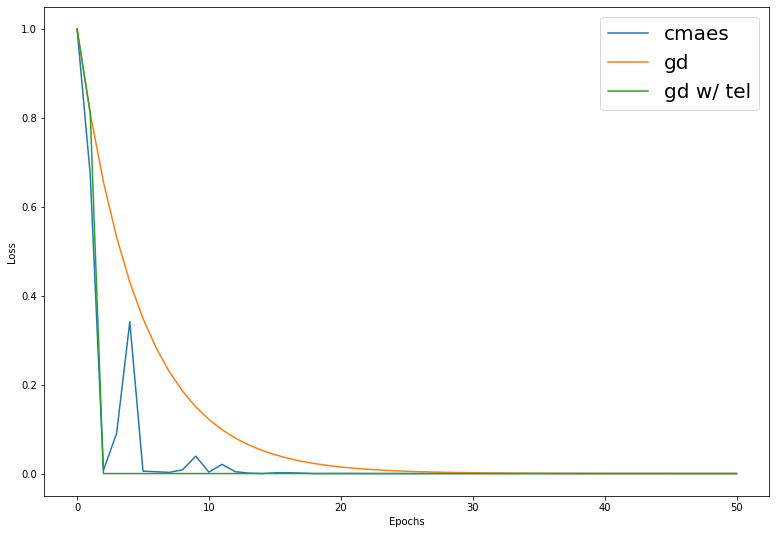

In [1129]:
ts = [[],[],[1]]
changes = [["gd","lr",0.05], ["cmaes","s",0.5]]
x_init = torch.tensor([1.0,0.0],requires_grad=True)
epochs = 50
loss_vs_epochs(ellipsoid, ["cmaes", "gd", "gd"], epochs, x_init, ts, changes)

Total epochs elapsed using cmaes - 46
Final x - tensor([-1.4878e-05,  1.6614e-06], grad_fn=<AddBackward0>)
Final loss - 2.489471684352651e-10
------------------------------
Total epochs elapsed using gd - 457
Final x - tensor([1.3633e-21, 0.0000e+00], grad_fn=<SubBackward0>)
Final loss - 1.8581217636947074e-42
------------------------------
Total epochs elapsed using gd w/ tel - 455
Final x - tensor([-2.9381e-25,  0.0000e+00], grad_fn=<SubBackward0>)
Final loss - 0.0
------------------------------


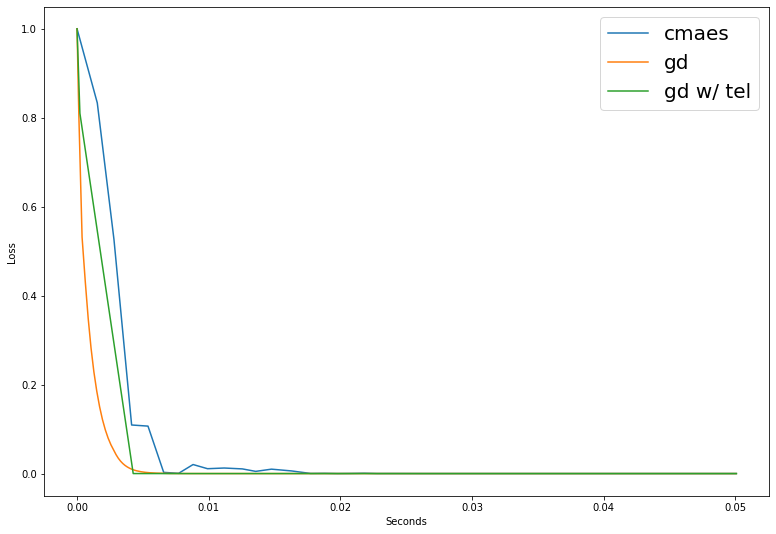

In [1135]:
ts = [[],[],[1]]
changes = [["gd","lr",0.05], ["cmaes","s",0.5]]
x_init = torch.tensor([1.0,0.0],requires_grad=True)
runtime = 0.05
loss_vs_seconds(ellipsoid, ["cmaes", "gd", "gd"], runtime, x_init, ts, changes)

### Booth

Total time elapsed using cmaes - 0.02834796905517578
Final x - tensor([1.0752, 3.0548], grad_fn=<AddBackward0>)
Final loss - 0.07628579437732697
------------------------------
Total time elapsed using gd - 0.003937959671020508
Final x - tensor([1.1835, 2.8165], grad_fn=<SubBackward0>)
Final loss - 0.06737586855888367
------------------------------
Total time elapsed using gd w/ tel - 0.009571075439453125
Final x - tensor([1.0993, 2.9007], grad_fn=<SubBackward0>)
Final loss - 0.01973884552717209
------------------------------


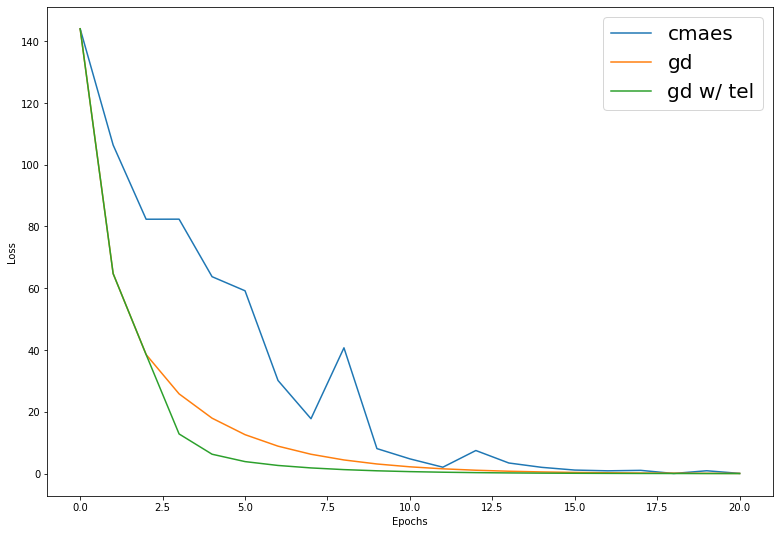

In [1136]:
ts = [[],[],[2]]
changes = [["gd","lr",0.08], ["cmaes","s",0.5]]
x_init = torch.tensor([5.0,-5.0],requires_grad=True)
epochs = 20
loss_vs_epochs(booth, ["cmaes", "gd", "gd"], epochs, x_init, ts, changes)

Total epochs elapsed using cmaes - 80
Final x - tensor([1.0000, 3.0000], grad_fn=<AddBackward0>)
Final loss - 9.094947017729282e-13
------------------------------
Total epochs elapsed using gd - 568
Final x - tensor([1.0000, 3.0000], grad_fn=<SubBackward0>)
Final loss - 4.547473508864641e-13
------------------------------
Total epochs elapsed using gd w/ tel - 527
Final x - tensor([1.0000, 3.0000], grad_fn=<SubBackward0>)
Final loss - 4.547473508864641e-13
------------------------------


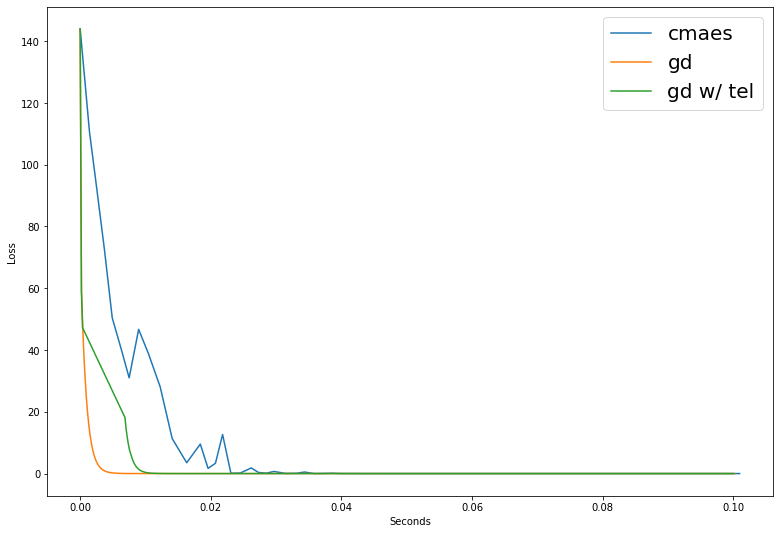

In [1138]:
ts = [[],[],[2]]
changes = [["gd","lr",0.05], ["cmaes","s",0.5]]
x_init = torch.tensor([5.0,-5.0],requires_grad=True)
runtime = 0.1
loss_vs_seconds(booth, ["cmaes", "gd", "gd"], runtime, x_init, ts, changes)

### Rosenbrock

Total time elapsed using cmaes - 0.12461996078491211
Final x - tensor([1.0000, 1.0000], grad_fn=<AddBackward0>)
Final loss - 3.588240815588506e-13
------------------------------
Total time elapsed using gd - 0.01712203025817871
Final x - tensor([0.1275, 0.0142], grad_fn=<SubBackward0>)
Final loss - 0.7617259621620178
------------------------------
Total time elapsed using gd w/ tel - 0.016949892044067383
Final x - tensor([0.1275, 0.0142], grad_fn=<SubBackward0>)
Final loss - 0.7617259621620178
------------------------------


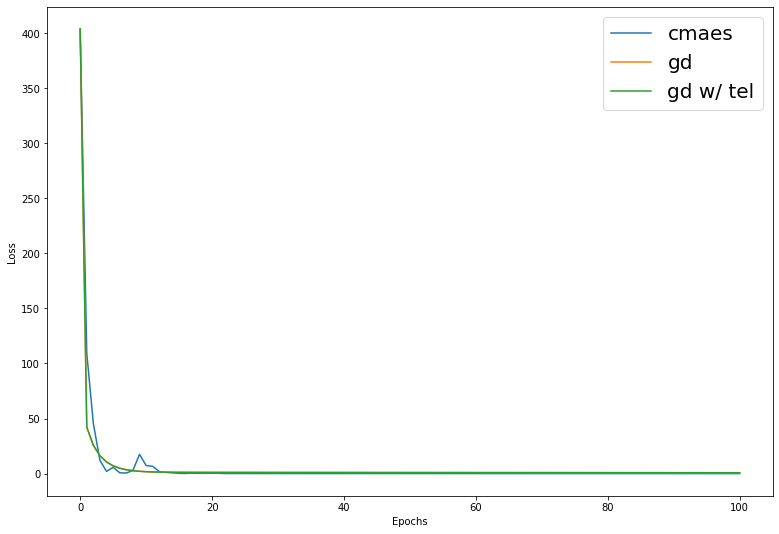

In [1149]:
ts = [[],[],[range(5,1000,20)]]
changes = [["gd","lr",0.001], ["cmaes","s",0.5]]
x_init = torch.tensor([-1.0,-1.0],requires_grad=True)
epochs = 100
loss_vs_epochs(rosenbrock, ["cmaes", "gd", "gd"], epochs, x_init, ts, changes)

Total epochs elapsed using cmaes - 85
Final x - tensor([1.0011, 1.0022], grad_fn=<AddBackward0>)
Final loss - 1.233923171639617e-06
------------------------------
Total epochs elapsed using gd w/ tel - 584
Final x - tensor([0.5327, 0.2814], grad_fn=<SubBackward0>)
Final loss - 0.21890844404697418
------------------------------
Total epochs elapsed using momentum - 574
Final x - tensor([0.9797, 0.9596], grad_fn=<AddBackward0>)
Final loss - 0.0004145916027482599
------------------------------
Total epochs elapsed using adagrad - 485
Final x - tensor([1., 1.], grad_fn=<SubBackward0>)
Final loss - 0.0
------------------------------


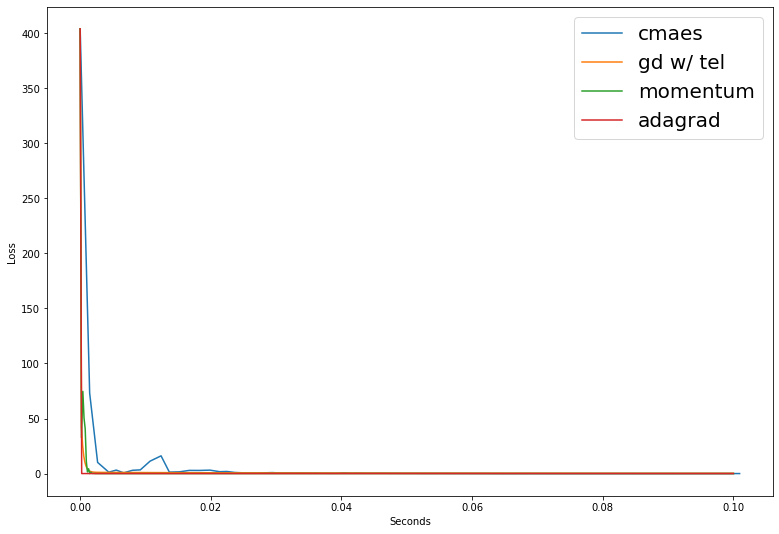

In [1160]:
ts = [[],[range(5,1000,20)],[],[]]
changes = [["gd","lr",0.001], ["cmaes","s",0.5], ["adagrad","lr",2]]
x_init = torch.tensor([-1.0,-1.0],requires_grad=True)
runtime = 0.1
loss_vs_seconds(rosenbrock, ["cmaes", "gd", "momentum", "adagrad"], runtime, x_init, ts, changes)

### Multi-layer Neural Network

In [1161]:
num_samples = 5
in_dim = 3
out_dim = 4
w_dims = [3, 10, 16, 8, 4]
num_weights = 0
for i in range(len(w_dims)-1):
    num_weights += w_dims[i] * w_dims[i+1]
w = torch.rand(num_weights)
X, Y = multi_layer_init(num_samples, in_dim, out_dim, w_dims)

Total time elapsed using adam - 0.11724019050598145
Final x - tensor([ 1.9312e-01, -4.5627e-01,  1.0606e-01, -6.9512e-01, -2.7948e-01,
        -3.3004e-01,  1.4428e-01, -3.0285e-02,  1.1189e-01, -3.7489e-01,
         2.0752e-01,  5.0342e-02, -2.1969e-01, -7.1491e-01,  4.8061e-02,
        -3.2277e-01, -1.0794e-01, -3.4843e-01, -2.5575e-01,  7.5373e-02,
        -5.0574e-01,  5.0481e-02, -8.0841e-02,  1.1973e-01, -3.7733e-01,
         9.1746e-02, -2.3799e-01, -4.4922e-02, -1.0874e-01,  3.4759e-02,
        -2.3131e-02,  4.2761e-02, -3.4184e-01, -7.2993e-01, -3.4455e-01,
        -4.3565e-01, -1.6732e-01, -4.9986e-01, -5.8065e-02, -4.7907e-01,
        -6.6803e-01, -2.5058e-01, -4.0450e-01, -4.9327e-01, -1.7405e-01,
        -5.1619e-01, -2.7300e-01, -4.2786e-01,  8.3997e-02, -4.5454e-02,
        -6.4929e-01, -1.8688e-01, -2.8077e-01, -6.3981e-01,  1.7298e-01,
        -4.5716e-01, -2.5518e-02, -2.6868e-01, -5.1124e-01, -4.3245e-01,
        -3.7958e-01, -6.3860e-01,  1.7697e-01, -4.6401e-01, -4

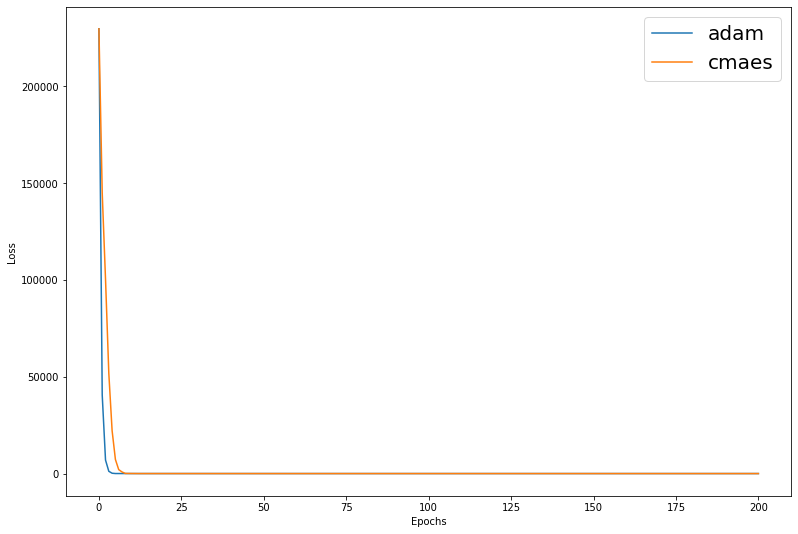

In [1189]:
ts = [[],[]]
x_init = torch.rand(num_weights, requires_grad=True)
changes = [["cmaes","s",0.5], ["adam","lr",0.1]]
epochs = 200
loss_vs_epochs(multi_layer, ["adam", "cmaes"], epochs, x_init, ts, changes)

Total epochs elapsed using adam - 3831
Final x - tensor([-1.4647e-01, -2.2940e-01,  3.0090e-01,  3.3359e-01,  3.1378e-01,
         6.2102e-01,  3.5454e-01,  3.7967e-01, -3.0990e-02,  1.7152e-01,
         2.2715e-01,  2.4653e-01, -1.4896e-01,  4.0855e-02, -1.5491e-01,
        -1.9881e-01,  2.3620e-01, -8.2201e-02, -1.2367e-01,  3.8224e-01,
         1.1206e-02,  6.3894e-02, -7.9623e-02,  3.0051e-01, -5.9971e-02,
         1.3322e-01,  1.4160e-01, -3.1964e-01,  2.2742e-01,  3.9823e-01,
        -8.6656e-02,  1.4215e-01,  2.3058e-01, -1.9205e-01,  1.8722e-01,
         1.1077e-01,  1.5917e-01,  6.5799e-01,  6.7911e-01,  5.9961e-01,
        -1.2172e-01,  3.3447e-01,  3.9099e-01, -1.7008e-01,  5.2099e-01,
         5.1786e-01,  5.0882e-01, -3.1686e-01, -2.0638e-01,  3.8902e-01,
        -6.3116e-02, -5.7886e-02,  6.0199e-02, -1.6809e-01, -1.2636e-02,
         2.5809e-02,  3.4639e-02,  8.7111e-02,  1.0873e-01, -6.7727e-02,
         4.5491e-01, -2.3045e-02, -1.0918e-01, -2.2987e-01,  8.8080e-02,
  

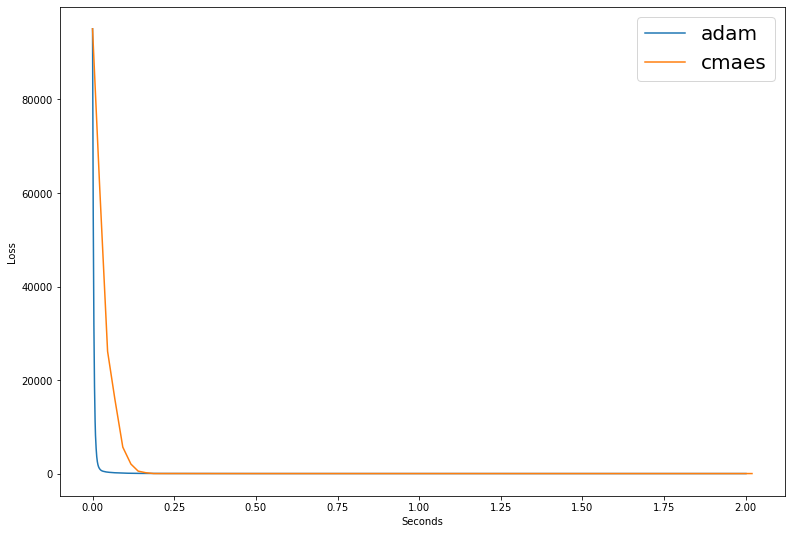

In [1195]:
ts = [[],[]]
x_init = torch.rand(num_weights, requires_grad=True)
changes = [["cmaes","s",0.5], ["adam","lr",0.01]]
runtime = 2
loss_vs_seconds(multi_layer, ["adam", "cmaes"], runtime, x_init, ts, changes)